In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import os
import datetime as dt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import BinaryEncoder
from category_encoders import HashingEncoder
# Libreria para estimar regresión
import statsmodels.formula.api as sm
# Libreria para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set_style('whitegrid')

sns.set(style="darkgrid")
dark_palette = sns.dark_palette("#d90429", as_cmap=True)

In [2]:
ruta = '/Users/Gerson/Desktop/Data-Science.'
os.chdir(ruta)

df = pd.read_excel("Amazon_Sales_Report.xlsx")

In [3]:
df.head()

,index,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,...,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Standard,SET389,SET389-KR-NP-S,Set,S,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship
1,1,171-9198151-1101146,04-30-22,Shipped,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Standard,J0341,J0341-DR-L,Western Dress,L,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN


**Limpieza de los datos**
---

In [4]:
df['Courier Status'].fillna('No especificado', inplace=True)
df['ship-city'].fillna('No especificado', inplace=True)
df['ship-state'].fillna('No especificado', inplace=True)
df['ship-postal-code'].fillna('No especificado', inplace=True)
df['ship-country'].fillna('No especificado', inplace=True)
df['promotion-ids'].fillna('No especificado', inplace=True)

df.dropna(subset=['currency', 'Amount'], inplace=True)

valores_faltantes_columnas = ["B2B", "fulfilled-by"]
datos_faltantes = df[valores_faltantes_columnas].isnull()

imputer = SimpleImputer(strategy='most_frequent')

df[valores_faltantes_columnas] = imputer.fit_transform(df[valores_faltantes_columnas])

# Elimino los guiones de la columna 'Order ID'
df['Order ID'] = df['Order ID'].str.replace('-', '')

# Convierto la columna a tipo numérico
df['Order ID'] = pd.to_numeric(df['Order ID'], errors='coerce')

#convierto el campo date en formato fecha.
df['Date']=pd.to_datetime(df['Date'])

/var/folders/kg/bj4nwrzj2k71bwdyw9wl8ll40000gp/T/ipykernel_5183/1665294042.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No especificado' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['ship-postal-code'].fillna('No especificado', inplace=True)
/var/folders/kg/bj4nwrzj2k71bwdyw9wl8ll40000gp/T/ipykernel_5183/1665294042.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


In [13]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[["Set", "kurta", "Western Dress", "Top", "Ethnic Dress", "Blouse", "Bottom", "Saree", "Dupatta"]])

# Ajustamos el codificador con la variable Fulfilment y la transformamos
encoder.fit(df[["Category"]])
df["Categoria_encoded"] = encoder.transform(df[["Category"]])

In [14]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[["Amazon", "Merchant"]])

# Ajustamos el codificador con la variable Fulfilment y la transformamos
encoder.fit(df[["Fulfilment"]])
df["Seller_encoded"] = encoder.transform(df[["Fulfilment"]])

**Variable Target:** 
***AMOUNT***
---

In [15]:
# Resumen estadístico variable target
descripcion = df['Amount'].describe()
print(descripcion)


count    121180.000000
mean        648.561465
std         281.211687
min           0.000000
25%         449.000000
50%         605.000000
75%         788.000000
max        5584.000000
Name: Amount, dtype: float64


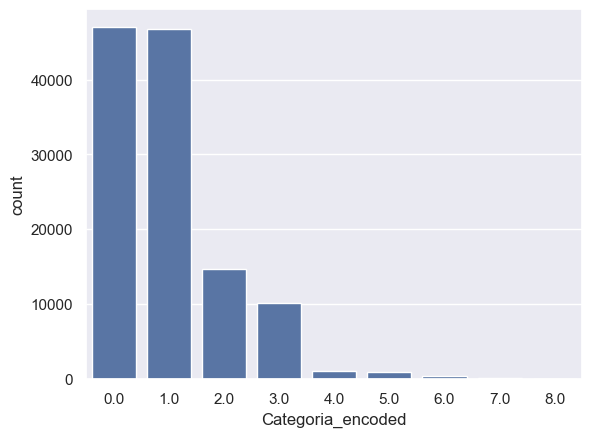

In [16]:
# Ventas por Categoria
plt.figure()
order = df['Categoria_encoded'].value_counts().index
sns.countplot(data = df,
              x = "Categoria_encoded",
              order=order)
plt.show()

In [17]:
df['Categoria_encoded'].value_counts()

Categoria_encoded
0.0    47042
1.0    46717
2.0    14704
3.0    10165
4.0     1093
5.0      881
6.0      420
7.0      155
8.0        3
Name: count, dtype: int64

***Clasificación***
---

Partes de Arriba: Top=3.0  Blouse=5.0


Partes de Abajo: Botton= 6.0

Vestido Tradicional: Kurta= 1.0, Ethnic Dress=4.0, Saree=7.0

Otros: Set=0.0 , Western Dress=2.0, Dupatta=8.0

In [20]:
#Funcion Clasificadora

def clasifica_Categoria_encoded(Categoria_encoded):
    if (Categoria_encoded in (3.0, 5.0)):
        return "1"
    elif (Categoria_encoded in (6.0, 8.0)):
        return "2"
    elif (Categoria_encoded in (1.0, 4.0, 7.0)):
        return "3"
    elif (Categoria_encoded in (0.0, 2.0)):
        return "4"    
    else:
        return "Sin_Dato"
    

df['Categoria_encoded_Bin'] =  df.apply(lambda row: clasifica_Categoria_encoded(row['Categoria_encoded']), 
                                 axis = 1)

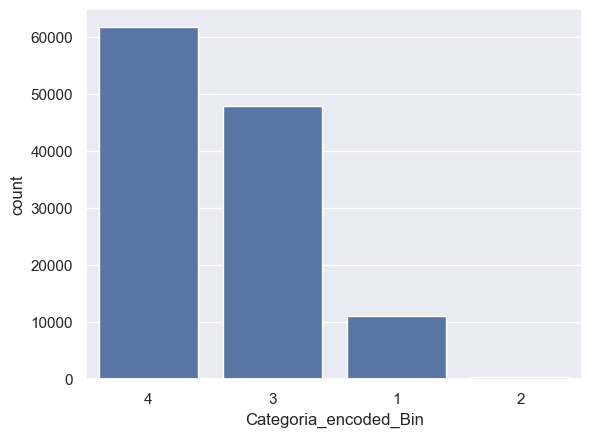

In [21]:
# Visualisamos como queda la cantidad una vez agrupada
plt.figure()
order = df['Categoria_encoded_Bin'].value_counts().index
sns.countplot(data = df,
              x = "Categoria_encoded_Bin",
              order=order)
plt.show()

Text(0.5, 1.0, 'Relación entre Categoria de Producto y su precio')

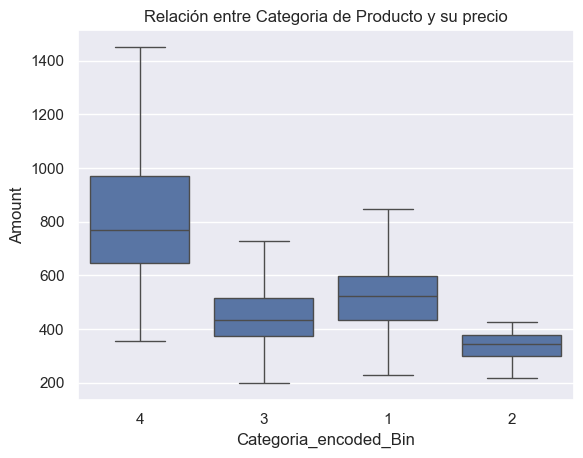

In [23]:
# Evaluo la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'Categoria_encoded_Bin',
            y = 'Amount', 
            showfliers = False,
            order=order)
plt.title('Relación entre Categoria de Producto y su precio')